# 분류 (MNIST datasets)

### 1. Data

##### 1-1. data load
- 기본적으로 사이킷런은 내려받은 데이터셋을 scikit_learn_data 디렉토리에 캐싱

- 사이킷런 데이터들은 일반적으로 비슷한 딕셔너리 구조
    - 데이터셋 설명하는 DESCR 키
    - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
    - 레이블 배열을 담은 target 키

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

c:\Users\jjjun_ii\anaconda3\envs\HOML\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

print(X.shape)  
print(y.shape)

# 이미지가 70,000개, 각 이미지의 특성 784개 => 28*28 픽셀
# 각 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도

(70000, 784)
(70000,)


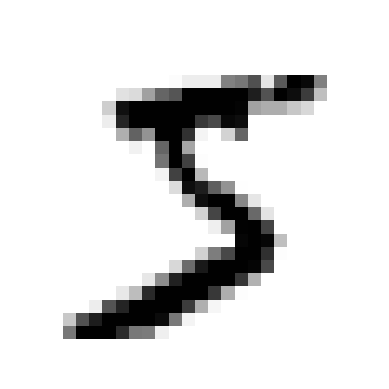

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# 레이블이 문자열, 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

import numpy as np

y = y.astype(np.uint8)

In [7]:
# 데이터 자세히 조사하기 전에 항상 테스트 세트 따로 떼어 놓기!!!
# MNIST 데이터셋은 이미 앞쪽 60,000개(훈련 세트), 뒤쪽 10,000개(테스트 세트)로 나눠둠

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**[Caution]**
<br> 훈련 세트는 섞여서 모든 교차 검증 폴드를 비슷하게 만들어야 함
<br> 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서
<br> 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐

### 2. 이진 분류기 훈련

##### 2-1. 이진 분류기
- 찾고 싶은 숫자와 아닌 숫자 분류

In [8]:
# 숫자 5만 식별

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# SGD(stochastic gradient descent)Classifier: 확률적 경사 하강법 분류기
# 매우 큰 데이터셋을 효율적으로 처리하는 장점, 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
# 그래서 SGD가 온라인 학습에 잘 들어맞음

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**[Tip]**
<br> SGDClassifier는 훈련하는데 무작위성을 사용(그래서 이름에 확률적이 붙음)
<br> 결과를 재현하고 싶다면 random_state 매개변수 사용

In [10]:
sgd_clf.predict([some_digit])  # some_digit = X[0]를 하나의 샘플로 인식하기 위해 []

array([ True])

### 3. 성능 측정
- 분류기 평가는 회귀 모델보다 훨씬 어려움

##### 3-1. 교차 검증

In [11]:
# 교차 검증 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):  # 3개로 분할된 형태
    clone_clf = clone(sgd_clf)  # sgd_clf의 복사본을 만듬, 각 폴드에 대해 모델을 독립적으로 훈련시키기 위해
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(train_index, test_index)

[    1     3     4 ... 59994 59996 59998] [    0     2     6 ... 59995 59997 59999]
[    0     2     3 ... 59997 59998 59999] [    1    10    11 ... 59988 59989 59991]
[    0     1     2 ... 59995 59997 59999] [    3     4     5 ... 59994 59996 59998]


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # 5가 아니므로 np.zeros로 모두 0을 만들면 False로 반환

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, scoring="accuracy", cv=3)

# 이미지의 10% 정도만 숫자 5이기 때문에 무조건 5아님으로 예측하면 맞출 확률이 90%

array([0.91125, 0.90855, 0.90915])

- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌

- 특히 불균형한 데이터셋을 다룰 때(어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그러함

##### 3-2. 오차 행렬
- 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

- 예를 들어 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨

In [16]:
# cross_val_predict: k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고
# 각 테스트 폴드에서 얻은 예측을 반환

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

**[오차 행렬]**
- 오차 행렬의 행은 실제 클래스, 열은 예측한 클래스

- 이 행렬의 첫 번째 행은 '5 아님'.
- 53,892개를 '5 아님'으로 정확하게 분류(true negative)  
- 687개를 '5'라고 잘못 분류(false positive)
- 두 번째 행은 '5'
- 1,891개를 '5 아님'으로 잘못 분류(false negative)
- 3,530개를 '5'라고 분류(true positive)

In [18]:
# 완벽한 분류기라면 왼쪽 위에서 오른쪽 아래만 0이 아닌 값

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- 오차 행렬이 많은 정보를 제공해주지만 더 요약된 지표가 필요할 때도 있음

- 살펴볼만한 것 하나는 양성 예측의 정확도
- **정밀도(precision)**: TP / (TP + FP)
- 정밀도는 재현율(recall) 이라는 지표와 사용하는 것이 일반적
- 재현율(recall) 은 분류기가 정확하게 감지한 양성 샘플의 비율, '민감도' 또는 '진짜 양성 비율이라고도 불림'
-  **재현율(recall)**: TP / (TP + FN)

##### 3-3. 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


- 5로 판별된 이미지 중 **83.7%** 정확함

- 전체 숫자 5에서 **65.1%** 감지

[F1 score]
- F1 score는 precision, recall의 조화 평균

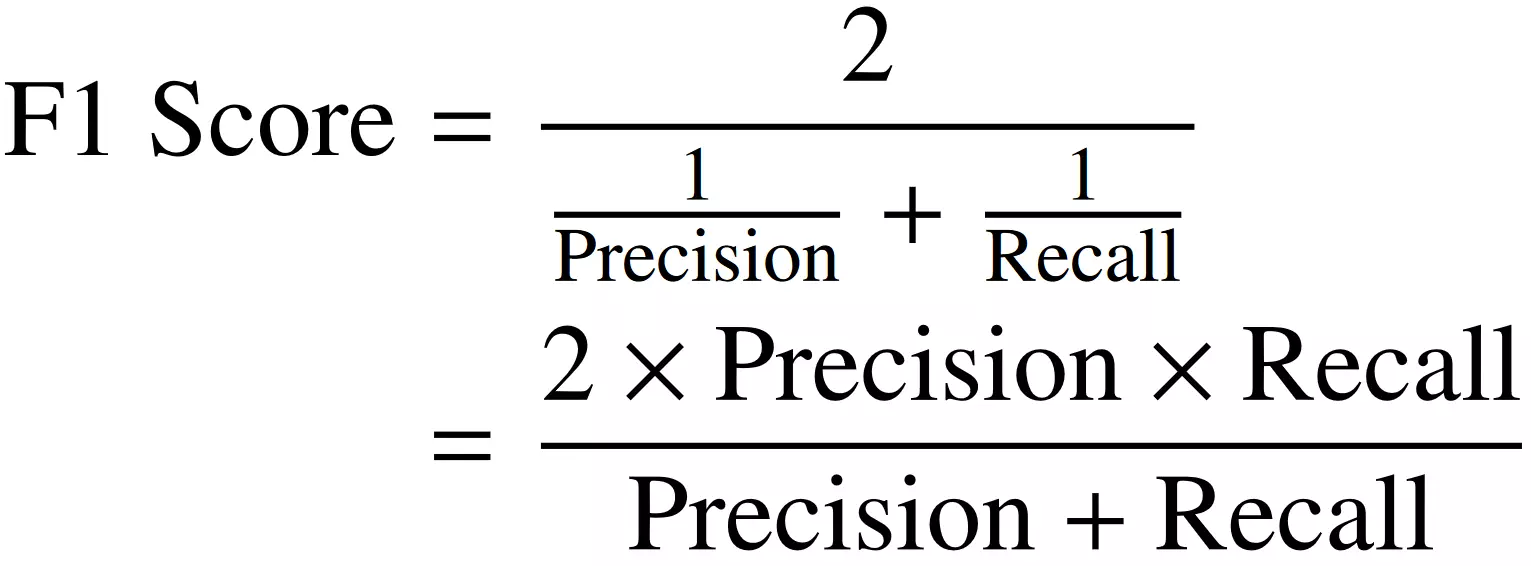

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 score가 높음

- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
- **예를 들어,** 어린아이에게 불건전한 동영상을 걸러내는 분류기 훈련
- 재현율은 높으나 불건전한 동영상이 몇 개 노출되는 것보다 
좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도)
분류기를 선호
- **다른 예로,** 감시 카메라를 통해 좀도둑을 잡아내는 분류기 훈련
- 재현율이 99%라면 정밀도가 30%가 되더라도 괜찮을지도 모름
(경비원이 잘못된 호출을 종종 받겠지만 거의 모든 좀도둑을 잡을 것임)
- 정밀도를 올리면 재현율이 줄고 반대도 마찬가지이므로, 정밀도/ 재현율 트레이드오프가 있음